# Análisis de Sentimiento de Tweets con Bag of Words

## Introducción

En este cuaderno Jupyter, se ha diseñado, programado y evaluado un modelo de tipo Bag of Words para realizar análisis de sentimiento sobre un dataset de Tweets. A continuación, se describen los pasos seguidos para resolver el ejercicio planteado:

### Obtención del Dataset y Preprocesamiento

Se utilizó la librería NLTK para obtener el dataset de Tweets. Los tweets positivos y negativos fueron descargados y preprocesados mediante una serie de técnicas de limpieza, tokenización y stemming. El preprocesamiento incluyó la eliminación de URLs, menciones, hashtags y stopwords, así como la reducción de palabras a su raíz mediante el algoritmo de Porter Stemmer.

### Cálculo de 1-gramas y 2-gramas

Para la representación de los tweets, se utilizó la técnica de Bag of Words, calculando tanto 1-gramas como 2-gramas. Esto se logró mediante el uso de la clase `CountVectorizer` de la librería scikit-learn, configurada para considerar n-gramas de longitud 1 y 2.

### División del Dataset en Train (con validación cruzada) y Test (para prueba final)

Para la división del dataset, estoy considerando la practica de MLOps donde se divide el dataset en 3 partes: Train, Validation y Test. 
En este caso, al incorporar la validación cruzada, se dividió el dataset en 2 partes: Train y Test, donde en Train se realizará validación cruzada generando el set de validación de forma dinámica y automática, mientras que el conjunto de prueba se utilizará para realizar la evaluación final de los modelos.
He utilizado la función `train_test_split` de scikit-learn para dividir el dataset en un 80% de datos de entrenamiento y un 20% de datos de prueba.
He agregado stratify para que se mantenga la proporción de clases en los conjuntos de entrenamiento y prueba.

### Construcción de Modelos Predictivos

Además de la regresión logística vista en clase, que utilizaré como Baseline, se construyeron y evaluaron otros modelos predictivos utilizando la representación Bag of Words. Los modelos considerados fueron:
- Regresión Logística (Baseline)
- Máquina de Vectores de Soporte (SVM)
- Árbol de Decisión
- Random Forest

### Evaluación y Comparación de Modelos

Para la evaluación y comparación de los modelos, se utilizaron diversas métricas de clasificación como accuracy, precisión, recall y F1-score. Además, se implementaron técnicas de validación cruzada y optimización de hiperparámetros mediante `GridSearchCV` para asegurar la solidez del análisis. También se graficaron la matriz de confusión y las cajas y bigotes de los resultados obtenidos en los diferentes modelos.

### Conclusión

El análisis realizado permitió comparar el desempeño de diferentes modelos predictivos en la tarea de análisis de sentimiento de Tweets, destacando la importancia del preprocesamiento y la optimización de hiperparámetros para obtener resultados robustos y confiables.

El mejor modelo en la comparación es el Decision Tree. Este modelo tiene la media más alta de precisión (0.9945) entre todos los modelos evaluados, lo que indica que, en promedio, tiene el mejor rendimiento. Además, aunque su desviación estándar (0.0064) es ligeramente mayor que la de los otros modelos, lo que sugiere una variabilidad un poco mayor en su rendimiento, su precisión máxima alcanza el 1.0 y su mínima es 0.9825, lo que demuestra que es consistentemente preciso en la mayoría de los casos.

# Código

In [1]:
!pip install nltk numpy pandas matplotlib scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.7/163.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 3.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 7.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 8.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 6.9 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 7.2 MB/s eta 0:00:0000:0100:01
   ━

In [2]:
# Importar las librerías necesarias
import nltk
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
import re
import string
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd


In [3]:
# Descargar los datos y stopwords
nltk.download('twitter_samples')
nltk.download('stopwords')

# Cargar los tweets positivos y negativos
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

# Función para preprocesar los tweets
def process_tweet(tweet):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
    
    tweets_clean = []
    for word in tweet_tokens:
        if word not in stopwords_english and word not in string.punctuation:
            stem_word = stemmer.stem(word)
            tweets_clean.append(stem_word)
    
    return tweets_clean

# Preprocesar los tweets
cleaned_positive_tweets = [process_tweet(tweet) for tweet in all_positive_tweets]
cleaned_negative_tweets = [process_tweet(tweet) for tweet in all_negative_tweets]

# Unir los tweets positivos y negativos
all_cleaned_tweets = cleaned_positive_tweets + cleaned_negative_tweets
labels = [1] * len(cleaned_positive_tweets) + [0] * len(cleaned_negative_tweets)

# Crear la representación Bag of Words con 1-gramas y 2-gramas
vectorizer = CountVectorizer(ngram_range=(1, 2), tokenizer=lambda x: x, preprocessor=lambda x: x)
features = vectorizer.fit_transform(all_cleaned_tweets)

print('Número de características:', features.shape[1])
print('Ejemplo de características:', vectorizer.get_feature_names_out()[:10])
print('Número de ejemplos:', features.shape[0])
print('Ejemplo de etiquetas:', labels[:10])


[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Número de características: 52919
Ejemplo de características: ['(-:' '(-: jesu' '(:' '(: (:' '(: :(' '(: exo' '(: sweet' '(: ♡' '):'
 '): ):']
Número de ejemplos: 10000
Ejemplo de etiquetas: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


/home/vscode/.local/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [4]:
# Para la división del dataset, estoy considerando la practica de MLOps donde se divide el dataset en 3 partes: Train, Validation y Test. 
# En este caso, al incorporar la validación cruzada, se dividió el dataset en 2 partes: Train y Test, 
# donde en Train se realizará validación cruzada generando el set de validación de forma dinámica y automática, mientras que el conjunto de prueba se utilizará para realizar la evaluación final de los modelos.
# Se usa un 80% de los datos para entrenamiento y un 20% para prueba.
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

In [5]:
# Hiperparámetros para Regresión Logística
log_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}

# Hiperparámetros para SVM
svm_param_grid = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf']
}

# Hiperparámetros para Árbol de Decisión
tree_param_grid = {
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# Hiperparámetros para Random Forest
forest_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# Optimización con GridSearchCV para Regresión Logística
log_grid_search = GridSearchCV(LogisticRegression(max_iter=200), log_param_grid, cv=5, scoring='accuracy')
log_grid_search.fit(X_train, y_train)
best_log_model = log_grid_search.best_estimator_
print(f"Best parameters (Logistic Regression): {log_grid_search.best_params_}")
print(f"Best CV Accuracy (Logistic Regression): {log_grid_search.best_score_}")

# Optimización con GridSearchCV para SVM
svm_grid_search = GridSearchCV(SVC(probability=True), svm_param_grid, cv=5, scoring='accuracy')
svm_grid_search.fit(X_train, y_train)
best_svm_model = svm_grid_search.best_estimator_
print(f"Best parameters (SVM): {svm_grid_search.best_params_}")
print(f"Best CV Accuracy (SVM): {svm_grid_search.best_score_}")

# Optimización con GridSearchCV para Árbol de Decisión
tree_grid_search = GridSearchCV(DecisionTreeClassifier(), tree_param_grid, cv=5, scoring='accuracy')
tree_grid_search.fit(X_train, y_train)
best_tree_model = tree_grid_search.best_estimator_
print(f"Best parameters (Decision Tree): {tree_grid_search.best_params_}")
print(f"Best CV Accuracy (Decision Tree): {tree_grid_search.best_score_}")


# Optimización con GridSearchCV para Random Forest
forest_grid_search = GridSearchCV(RandomForestClassifier(), forest_param_grid, cv=5, scoring='accuracy')
forest_grid_search.fit(X_train, y_train)
best_forest_model = forest_grid_search.best_estimator_
print(f"Best parameters (Random Forest): {forest_grid_search.best_params_}")
print(f"Best CV Accuracy (Random Forest): {forest_grid_search.best_score_}")



Best parameters (Logistic Regression): {'C': 10, 'solver': 'lbfgs'}
Best CV Accuracy (Logistic Regression): 0.9966250000000001
Best parameters (SVM): {'C': 1, 'kernel': 'linear'}
Best CV Accuracy (SVM): 0.9964999999999999
Best parameters (Decision Tree): {'max_depth': 10, 'min_samples_split': 2}
Best CV Accuracy (Decision Tree): 0.9945
Best parameters (Random Forest): {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best CV Accuracy (Random Forest): 0.9959999999999999


In [6]:
# Muestra de los resultados
print("Logistic Regression")
print(classification_report(y_test, best_log_model.predict(X_test)))
print("SVM")
print(classification_report(y_test, best_svm_model.predict(X_test)))
print("Decision Tree")
print(classification_report(y_test, best_tree_model.predict(X_test)))
print("Random Forest")
print(classification_report(y_test, best_forest_model.predict(X_test)))



Logistic Regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

SVM
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1000
           1       1.00      0.99      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Decision Tree
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1000
           1       0.99      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00   

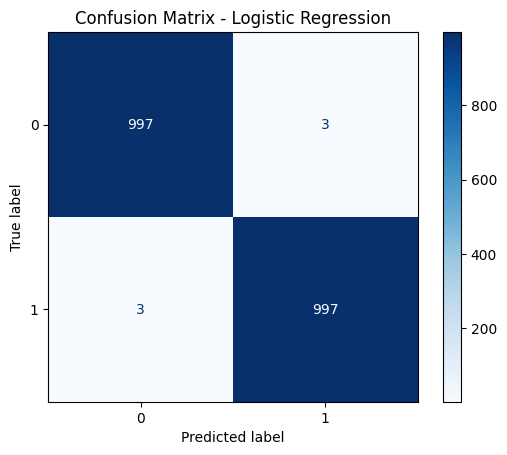

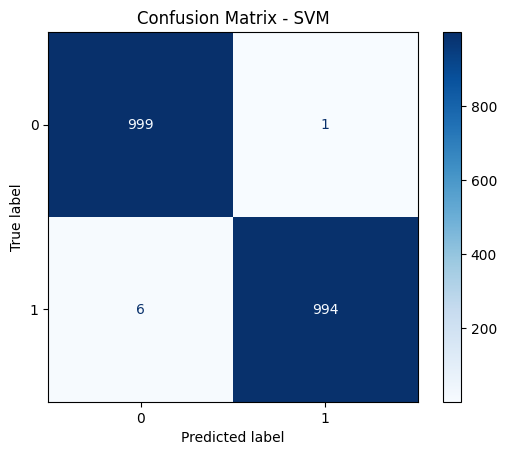

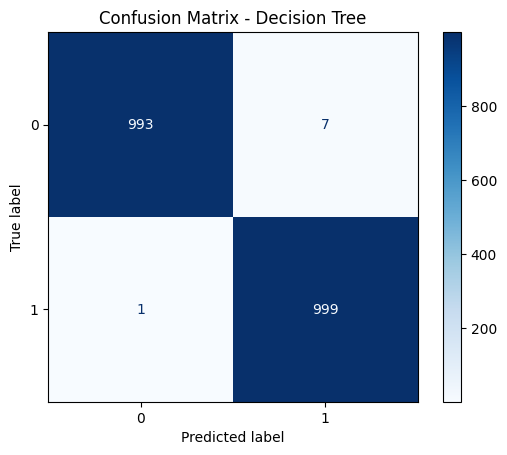

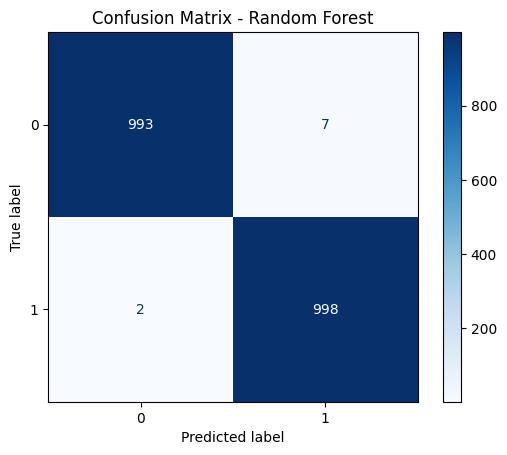

In [7]:
# Función para graficar la matriz de confusión usando matplotlib
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

# Graficar la matriz de confusión para los modelos
plot_confusion_matrix(y_test, best_log_model.predict(X_test), 'Logistic Regression')
plot_confusion_matrix(y_test, best_svm_model.predict(X_test), 'SVM')
plot_confusion_matrix(y_test, best_tree_model.predict(X_test), 'Decision Tree')
plot_confusion_matrix(y_test, best_forest_model.predict(X_test), 'Random Forest')


Logistic Regression: mean 0.9935  std 0.005385164807134518 max 1.0  min 0.985
SVM: mean 0.993  std 0.005787918451395116 max 1.0  min 0.985
Decision Tree: mean 0.9945  std 0.006403124237432833 max 1.0  min 0.9825
Random Forest: mean 0.9935  std 0.004358898943540662 max 1.0  min 0.9875


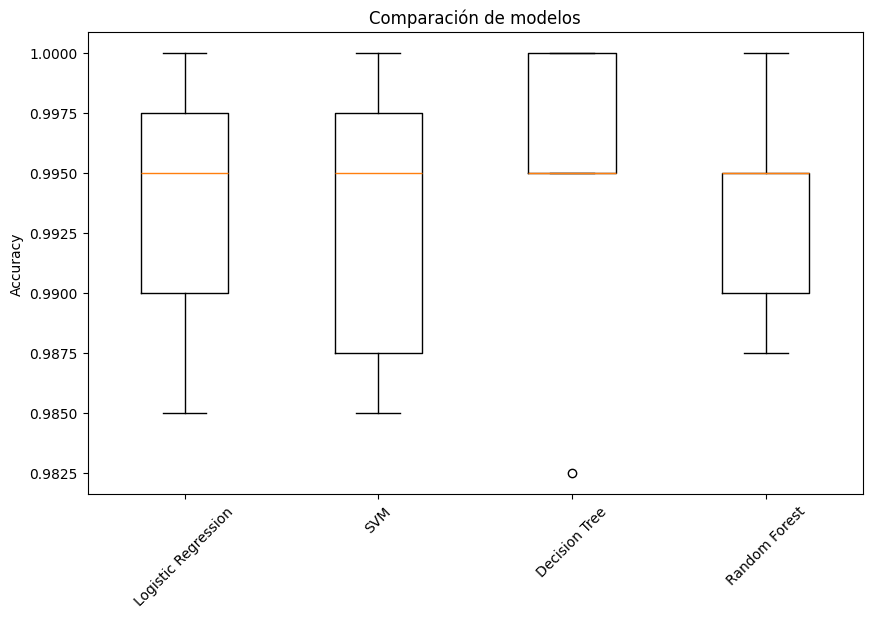

In [8]:
results = {}
results['Logistic Regression'] = cross_val_score(best_log_model, X_test, y_test, cv=5)
results['SVM'] = cross_val_score(best_svm_model, X_test, y_test, cv=5)
results['Decision Tree'] = cross_val_score(best_tree_model, X_test, y_test, cv=5)
results['Random Forest'] = cross_val_score(best_forest_model, X_test, y_test, cv=5)

# Resultados
for name, scores in results.items():
    print(f'{name}: mean {np.mean(scores)}  std {np.std(scores)} max {np.max(scores)}  min {np.min(scores)}')

# Gráfico de cajas y bigotes
plt.figure(figsize=(10, 6))
plt.boxplot([results['Logistic Regression'], results['SVM'], results['Decision Tree'], results['Random Forest']], tick_labels=['Logistic Regression', 'SVM', 'Decision Tree', 'Random Forest'])
plt.title('Comparación de modelos')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

El mejor modelo en la comparación es el Decision Tree. Este modelo tiene la media más alta de precisión (0.9945) entre todos los modelos evaluados, lo que indica que, en promedio, tiene el mejor rendimiento. Además, aunque su desviación estándar (0.0064) es ligeramente mayor que la de los otros modelos, lo que sugiere una variabilidad un poco mayor en su rendimiento, su precisión máxima alcanza el 1.0 y su mínima es 0.9825, lo que demuestra que es consistentemente preciso en la mayoría de los casos.